# Demonstration of CVAE Model

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd

from data_enricher.models import *
from data_enricher.utils import *
from data_enricher.comparison import *


Load Data

In [8]:
# Load data as dataframe
df = pd.read_csv('data/toy_data.csv')
x, y = torch.tensor(df.iloc[:,:2].values, dtype=torch.float32), torch.tensor(df.iloc[:,-1].values, dtype=torch.int64)
y_one_hot = torch.nn.functional.one_hot(y).float()
# randomly split data into train and test
train_idx = np.random.choice(x.shape[0], int(0.8 * x.shape[0]), replace=False)
test_idx = np.setdiff1d(np.arange(x.shape[0]), train_idx)
train_data, train_cond, train_cond_one_hot = x[train_idx], y[train_idx], y_one_hot[train_idx]
test_data, test_cond, test_cond_one_hot = x[test_idx], y[test_idx], y_one_hot[test_idx]

Initialize Model

In [23]:
model = VAE(input_dim=train_data.shape[1], cond_dim=train_cond_one_hot.shape[1], latent_dim=2, num_hidden_layers=1, num_neurons=3,)

Train Model

In [24]:
model.train(x=train_data, conditions=train_cond_one_hot, beta=0.5, mc_samples=2, learning_rate=2e-3, epochs=50, batch_size=32)

Iteration: 100/1250 -- ELBO=-2.47e+00 / RLL=-2.47e+00 / KL=3.87e-04
Iteration: 200/1250 -- ELBO=-1.41e+00 / RLL=-1.41e+00 / KL=4.51e-04
Iteration: 300/1250 -- ELBO=-1.44e+00 / RLL=-1.44e+00 / KL=5.12e-04
Iteration: 400/1250 -- ELBO=-1.52e+00 / RLL=-1.52e+00 / KL=1.62e-04
Iteration: 500/1250 -- ELBO=-1.07e+00 / RLL=-1.07e+00 / KL=3.50e-04
Iteration: 600/1250 -- ELBO=-1.07e+00 / RLL=-1.07e+00 / KL=1.61e-04
Iteration: 700/1250 -- ELBO=-9.43e-01 / RLL=-9.43e-01 / KL=1.09e-04
Iteration: 800/1250 -- ELBO=-9.29e-01 / RLL=-9.29e-01 / KL=2.14e-04
Iteration: 900/1250 -- ELBO=-8.81e-01 / RLL=-8.80e-01 / KL=2.63e-04
Iteration: 1000/1250 -- ELBO=-1.08e+00 / RLL=-1.08e+00 / KL=1.93e-04
Iteration: 1100/1250 -- ELBO=-8.84e-01 / RLL=-8.84e-01 / KL=1.71e-04
Iteration: 1200/1250 -- ELBO=-8.51e-01 / RLL=-8.50e-01 / KL=3.97e-04


Take Samples for Visualization

In [27]:
num_samples = train_data.shape[0]
condition = y_one_hot[1]

sample_param_dict = model.sample(num_samples_prior=num_samples, num_samples_likelihood=3, conditions=condition)

samples = sample_param_dict["samples"].flatten(end_dim=1).detach().numpy()

train_data_list = [['Training data']+x for x in train_data.tolist()]
sample_list = [['Generated data']+x for x in samples.tolist()]
pair_df = pd.DataFrame(train_data_list+sample_list,columns=['type','x_1', 'x_2'])

Compare Samples Visually

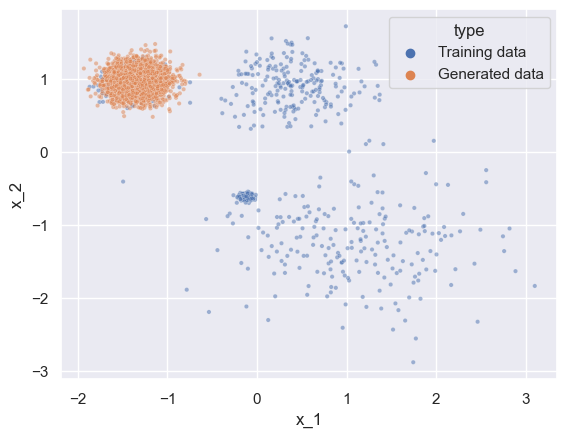

In [28]:
sns.scatterplot(data=pair_df, x='x_1', y='x_2', hue='type', s=10, alpha=0.5)

plt.show()

Sample and Model Comparison Scores

In [39]:
all_samples = torch.tensor([])
num_samples = train_data.shape[0]//model.cond_dim
for condition in train_cond_one_hot.unique(dim=0):

    sample_param_dict = model.sample(num_samples_prior=num_samples, num_samples_likelihood=1, conditions=condition)

    samples = sample_param_dict["samples"].flatten(end_dim=1).detach()

    all_samples = torch.cat((all_samples, samples), dim=0)

sample_test = "mmd"
model_scores, base_scores = sample_comparison(model_samples=all_samples, train_samples=train_data, test_samples=test_data, test=sample_test, subsample_ratio=0.4, mc_runs=1000)

In [40]:
model_test = "ks"
model_score = model_comparison(model_scores=model_scores, base_scores=base_scores, test=model_test)

[]

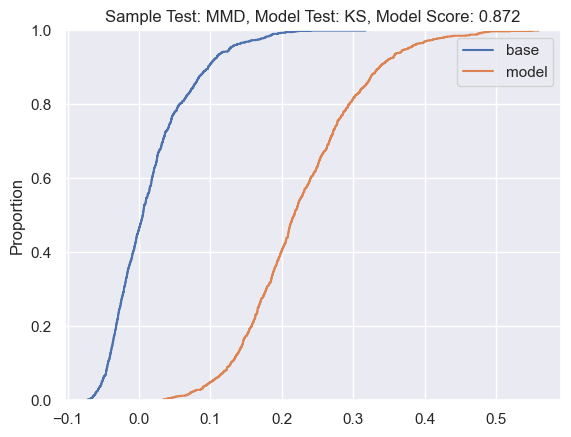

In [41]:
sns.ecdfplot(base_scores, label='base')
sns.ecdfplot(model_scores, label='model')
plt.legend()
plt.title(f"Sample Test: {sample_test.upper()}, Model Test: {model_test.upper()}, Model Score: {model_score:.3f}")
plt.plot()